In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import re
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [ ]:
def get_data_loaders(train_batch_size, val_batch_size):
    fashion_mnist = torchvision.datasets.FashionMNIST(download=True, train=True, root=".").train_data.float()
    
    data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])

    train_loader = DataLoader(torchvision.datasets.FashionMNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(torchvision.datasets.FashionMNIST(download=True, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader

In [ ]:
def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
      if sum(scores)/batch_size > 0.001:
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [ ]:
def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child! :O
        return model
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [ ]:
def resnet_print_sparcity(model, print_spar=True):
    layers = [(module, 'weight') for module in get_children(model)\
                        if (isinstance(module, torch.nn.modules.conv.Conv2d) or isinstance(module, torch.nn.modules.Linear))]
    if print_spar:  
        for lay in layers:
            print("Sparsity in {}: {:.2f}%".format(
                lay[0],
            100. * float(torch.sum(lay[0].weight == 0))
            / float(lay[0].weight.nelement())
        ))

    w_0 = 0
    w_neel = 0

    for lay in layers:
        w_0 += torch.sum(lay[0].weight == 0)
        w_neel += lay[0].weight.nelement()
    
    glob_sparc = 100. * float(w_0) / float(w_neel)

    if print_spar:
        print(
            "Global sparsity: {:.2f}%".format(glob_sparc)
        )

    return glob_sparc
   

In [ ]:
def resnet_training(train_loader, val_loader, model, epochs, loss_function, optimizer):
    start_ts = time.time()

    losses = []
    accs = []
    batches = len(train_loader)
    val_batches = len(val_loader)

    # loop for every epoch (training + evaluation)
    for epoch in range(epochs):
        total_loss = 0

        # progress bar (works in Jupyter notebook too!)
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    #    ----------------- TRAINING  -------------------- 
        #set model to training
        model.train()
        
        for i, data in progress:
            X, y = data[0].to(device), data[1].to(device)
            
            # training step for single batch
            model.zero_grad()
            outputs = model(X)
            loss = loss_function(outputs, y)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            # getting training quality data
            current_loss = loss.item()
            total_loss += current_loss

            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.to(device)
            # correct = (predicted == data[1]).sum().item()
            correct = (predicted == data[1].to(device))
            correct = correct.sum()
            correct = correct.item()
            accs.append(correct / data[1].to(device).size(0))
            
            # updating progress bar
            progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
            
        # releasing unceseccary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"Training time: {time.time()-start_ts}s")

    return losses, accs

In [ ]:
def save_model(model, model_dir, model_filename):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.save(model.state_dict(), model_filepath)


def load_model(model, model_filepath, device):

    model.load_state_dict(torch.load(model_filepath, map_location=device))

    return model

def flatten(t):
    t = t.reshape(1, -1)
    t = t.squeeze()
    return t

In [ ]:
class MnistResNet(nn.Module):
  def __init__(self, in_channels=1):
    super(MnistResNet, self).__init__()

    # Load a pretrained resnet model from torchvision.models in Pytorch
    self.model = models.resnet18(pretrained=False)

    # Change the input layer to take Grayscale image, instead of RGB images. 
    # Hence in_channels is set as 1 or 3 respectively
    # original definition of the first layer on the ResNet class
    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Change the output layer to output 10 classes instead of 1000 classes
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 10)

  def forward(self, x):
    return self.model(x)

In [ ]:
model = MnistResNet().to(device)
# model_state_dict = torch.load("tmp/MnistResNet")
# model.load_state_dict(model_state_dict)

In [ ]:
def get_resnet_modules(model):
    return [(module, 'weight') for module in get_children(model) if (isinstance(module, torch.nn.modules.conv.Conv2d) or isinstance(module, torch.nn.modules.Linear))]

In [ ]:
get_resnet_modules(model)

[(Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
  'weight'),
 (Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
  'weight'),
 (Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
  'weight'),
 (Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
  'weight'),
 (Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
  'weight'),
 (Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
  'weight'),
 (Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
  'weight'),
 (Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False), 'weight'),
 (Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
  'weight'),
 (Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
  'weight'),
 (Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b

In [ ]:
[i[0] for i in get_resnet_modules(model)]

[Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 256, kernel_size=(1, 1), stride=

In [ ]:
batch_size = 50

# Dataloaders
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
def resnet_eval(model):
    val_losses = 0

    precision, recall, f1, accuracy = [], [], [], []

    loss_function = nn.CrossEntropyLoss()
    val_batches = len(val_loader)
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            accuracy.append(
                calculate_metric(accuracy_score, y.cpu(), predicted_classes.cpu())
            )
          
    print_scores(precision, recall, f1, accuracy, val_batches)

    return sum(accuracy)/val_batches

In [ ]:
resnet_eval(model)

	      accuracy: 0.1000


0.09999999999999998

In [ ]:
import torch.nn.utils.prune as prune
import torch.nn.functional as F

In [ ]:
def one_shot_resnet_prune(model_inp, percent):
    model = MnistResNet().to(device)

    model.load_state_dict(model_inp.state_dict())
    parameters_to_prune = [(module, 'weight') for module in get_children(model)\
                       if (isinstance(module, torch.nn.modules.conv.Conv2d) or isinstance(module, torch.nn.modules.Linear))]

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=percent,
    )

    return model

In [ ]:
learning_rate = 0.01
batch_size = 50
num_epochs = 2
DATA_PATH = 'mnist_data'
perc = 0.3

In [ ]:
model_it =  MnistResNet().to(device)
loss_func = nn.CrossEntropyLoss()
optim_func = torch.optim.Adam(model_it.parameters(), lr=learning_rate)

untr_model = MnistResNet().to(device)
untr_model.load_state_dict(model_it.state_dict())


# distances non trained vs trained
results_bp = dict()
# distances non trained vs pruned+trained
results_ap = dict()
for name, module in untr_model.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.modules.Linear):
        results_bp[name] = None
        results_ap[name] = []

untr_modules = [i[0] for i in get_resnet_modules(untr_model)]
modules = [i[0] for i in get_resnet_modules(model_it)]

for indx in range(len(untr_modules)):
        
    untr_1l = untr_modules[indx].weight.data
    untr_1l_distr = F.log_softmax(flatten(untr_1l), -1)
    
    model_1l = modules[indx].weight.data
    model_1l_distr = F.softmax(flatten(model_1l), -1)

    print(list([i for i in results_ap.keys()])[indx],torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, model_1l_distr))

    results_bp[list([i for i in results_ap.keys()])[indx]] = torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, model_1l_distr).item()

model.conv1 tensor(-6.3095e-08, device='cuda:0')
model.layer1.0.conv1 tensor(3.5178e-07, device='cuda:0')
model.layer1.0.conv2 tensor(4.7956e-08, device='cuda:0')
model.layer1.1.conv1 tensor(4.7028e-09, device='cuda:0')
model.layer1.1.conv2 tensor(-1.5200e-07, device='cuda:0')
model.layer2.0.conv1 tensor(-8.7575e-08, device='cuda:0')
model.layer2.0.conv2 tensor(-2.1359e-07, device='cuda:0')
model.layer2.0.downsample.0 tensor(7.5073e-09, device='cuda:0')
model.layer2.1.conv1 tensor(-2.8793e-07, device='cuda:0')
model.layer2.1.conv2 tensor(3.4733e-07, device='cuda:0')
model.layer3.0.conv1 tensor(2.2157e-07, device='cuda:0')
model.layer3.0.conv2 tensor(5.0096e-08, device='cuda:0')
model.layer3.0.downsample.0 tensor(-8.3625e-09, device='cuda:0')
model.layer3.1.conv1 tensor(-2.6234e-07, device='cuda:0')
model.layer3.1.conv2 tensor(4.5245e-07, device='cuda:0')
model.layer4.0.conv1 tensor(-4.6217e-07, device='cuda:0')
model.layer4.0.conv2 tensor(3.3972e-07, device='cuda:0')
model.layer4.0.dow

In [ ]:
print("Model training for hyperparamethers batch size = {}, learning rate alpha = {}".format(batch_size, learning_rate))
loss_list, acc_list = resnet_training(train_loader, val_loader, model_it, num_epochs, loss_func, optim_func)

iterative_accs_bft = dict()
iterative_accs_aft = dict()

accuracy = resnet_eval(model_it)
sparcity = resnet_print_sparcity(model_it, print_spar=True)

for i in range(8):
    parameters_to_prune = get_resnet_modules(model_it)

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=perc,
    )

    accuracy = resnet_eval(model_it)
    sparcity = resnet_print_sparcity(model_it, print_spar=True)
    iterative_accs_bft[sparcity] = accuracy

    it_modules = [i[0] for i in get_resnet_modules(model_it)]
    for indx in range(len(untr_modules)):

        untr_1l = untr_modules[indx].weight.data
        untr_1l_distr = F.log_softmax(flatten(untr_1l), -1)

        it_model_1l = it_modules[indx].weight.data
        it_model_1l_distr = F.softmax(flatten(it_model_1l), -1)

        # print(torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, it_model_1l_distr).item())

        results_ap[list([i for i in results_ap.keys()])[indx]].append(torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, it_model_1l_distr).item())

    print("Fine-tuning...")

    print("Model training for hyperparamethers batch size = {}, learning rate alpha = {}".format(batch_size, learning_rate))
    loss_list, acc_list = resnet_training(train_loader, val_loader, model_it, num_epochs, loss_func, optim_func)
    accuracy_ft = resnet_eval(model_it)

    sparcity_ft = resnet_print_sparcity(model_it, print_spar=True)
    iterative_accs_aft[sparcity_ft] = accuracy_ft


    model_filename_prefix="pruned_model"
    model_dir="saved_models"

    model_filename = "{}_{}".format(model_filename_prefix, i + 1)
    model_filepath = os.path.join(model_dir, model_filename)

    save_model(model_it, model_dir, model_filename)
    model_it = load_model(model_it, model_filepath, device)

    it_modules = [i[0] for i in get_resnet_modules(model_it)]
    for indx in range(len(untr_modules)):

        untr_1l = untr_modules[indx].weight.data
        untr_1l_distr = F.log_softmax(flatten(untr_1l), -1)

        it_model_1l = it_modules[indx].weight.data
        it_model_1l_distr = F.softmax(flatten(it_model_1l), -1)

        #print(torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, it_model_1l_distr).item())

        results_ap[list([i for i in results_ap.keys()])[indx]].append(torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, it_model_1l_distr).item())


Model training for hyperparamethers batch size = 50, learning rate alpha = 0.01


Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Training time: 879.6343219280243s
	      accuracy: 0.9008
Sparsity in Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False): 0.00%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 0.00%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 0.00%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 0.00%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 0.00%
Sparsity in Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False): 0.00%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 0.00%
Sparsity in Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False): 0.00%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 0.00%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Training time: 876.2303040027618s
	      accuracy: 0.9162
Sparsity in Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False): 28.92%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 35.81%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 33.68%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 36.59%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 34.19%
Sparsity in Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False): 36.86%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 34.64%
Sparsity in Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False): 20.23%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 39.94%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Training time: 873.7576594352722s
	      accuracy: 0.9224
Sparsity in Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False): 51.91%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 61.41%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 58.68%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 64.27%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 59.63%
Sparsity in Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False): 59.66%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 56.06%
Sparsity in Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False): 37.90%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 63.69%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Training time: 873.8557324409485s
	      accuracy: 0.9238
Sparsity in Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False): 68.34%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 78.69%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 75.17%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 81.67%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 77.88%
Sparsity in Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False): 73.90%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 70.32%
Sparsity in Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False): 53.45%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 77.49%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Training time: 870.9174273014069s
	      accuracy: 0.9328
Sparsity in Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False): 78.28%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 86.72%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 84.71%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 89.84%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 87.10%
Sparsity in Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False): 82.06%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 78.91%
Sparsity in Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False): 65.72%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 84.97%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Training time: 867.4118058681488s
	      accuracy: 0.9337
Sparsity in Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False): 85.97%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 91.62%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 90.61%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 94.09%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 92.17%
Sparsity in Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False): 87.76%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 85.18%
Sparsity in Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False): 75.49%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 89.80%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Training time: 866.655303478241s
	      accuracy: 0.9303
Sparsity in Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False): 90.53%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 94.60%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 94.06%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 96.47%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 95.10%
Sparsity in Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False): 91.98%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 89.73%
Sparsity in Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False): 82.63%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 93.20%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Training time: 864.1642439365387s
	      accuracy: 0.9287
Sparsity in Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False): 94.16%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 96.61%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 96.28%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 98.01%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 97.05%
Sparsity in Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False): 94.68%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 93.24%
Sparsity in Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False): 88.53%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 95.57%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Training time: 861.5135912895203s
	      accuracy: 0.9269
Sparsity in Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False): 96.11%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 97.81%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 97.71%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 98.82%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 98.13%
Sparsity in Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False): 96.62%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 95.64%
Sparsity in Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False): 92.49%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 97.16%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding

In [ ]:
iterative_accs_bft

{30.0: 0.8991000000000006,
 51.00000358238042: 0.8521000000000004,
 65.70000609004671: 0.4474000000000001,
 75.98999978505718: 0.7479000000000003,
 83.19300253632534: 0.251,
 88.23510446221304: 0.3259000000000001,
 91.76457312354914: 0.3764,
 94.23519760410397: 0.21619999999999998}

In [ ]:
iterative_accs_aft

{30.0: 0.9161999999999995,
 51.00000358238042: 0.9223999999999988,
 65.70000609004671: 0.9237999999999993,
 75.98999978505718: 0.932799999999999,
 83.19300253632534: 0.9336999999999993,
 88.23510446221304: 0.9302999999999996,
 91.76457312354914: 0.9286999999999995,
 94.23519760410397: 0.9268999999999993}

In [ ]:
results_bp

{'model.conv1': -6.309458200348672e-08,
 'model.fc': -3.8081498132669367e-07,
 'model.layer1.0.conv1': 3.5177592394575186e-07,
 'model.layer1.0.conv2': 4.795613861574566e-08,
 'model.layer1.1.conv1': 4.702779499154985e-09,
 'model.layer1.1.conv2': -1.519956356332841e-07,
 'model.layer2.0.conv1': -8.757508140888604e-08,
 'model.layer2.0.conv2': -2.135901695510256e-07,
 'model.layer2.0.downsample.0': 7.507280130880645e-09,
 'model.layer2.1.conv1': -2.879274347833416e-07,
 'model.layer2.1.conv2': 3.4732502740553173e-07,
 'model.layer3.0.conv1': 2.2156939394335495e-07,
 'model.layer3.0.conv2': 5.009581016679476e-08,
 'model.layer3.0.downsample.0': -8.36249558489044e-09,
 'model.layer3.1.conv1': -2.6233522021357203e-07,
 'model.layer3.1.conv2': 4.5245440105645685e-07,
 'model.layer4.0.conv1': -4.62165246517543e-07,
 'model.layer4.0.conv2': 3.39716564212722e-07,
 'model.layer4.0.downsample.0': -3.906991423718864e-07,
 'model.layer4.1.conv1': 1.0001473782494941e-07,
 'model.layer4.1.conv2': 4

In [ ]:
results_ap

{'model.conv1': [0.012083016335964203,
  0.02499297633767128,
  0.02493571862578392,
  0.04779558628797531,
  0.046725645661354065,
  0.07186922430992126,
  0.06797726452350616,
  0.08437769114971161,
  0.07587802410125732,
  0.10190917551517487,
  0.09079455584287643,
  0.11436324566602707,
  0.10072046518325806,
  0.1149335652589798,
  0.09939025342464447,
  0.1158929094672203],
 'model.fc': [0.010993128642439842,
  0.026553388684988022,
  0.026104815304279327,
  0.04531067609786987,
  0.042908765375614166,
  0.0663195550441742,
  0.060464464128017426,
  0.08302745223045349,
  0.0725959986448288,
  0.0901053175330162,
  0.07741968333721161,
  0.09057910740375519,
  0.07718127965927124,
  0.09101974964141846,
  0.07284891605377197,
  0.08442087471485138],
 'model.layer1.0.conv1': [0.010338702239096165,
  0.024224868044257164,
  0.023922286927700043,
  0.04451366886496544,
  0.04324386268854141,
  0.08377212285995483,
  0.08162674307823181,
  0.11760088801383972,
  0.11400554329156876,

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
list(iterative_accs_bft.keys())

[30.0,
 51.00000358238042,
 65.70000609004671,
 75.98999978505718,
 83.19300253632534,
 88.23510446221304,
 91.76457312354914,
 94.23519760410397]

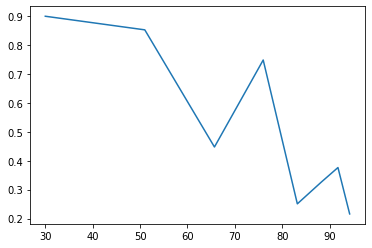

In [ ]:
x = list(iterative_accs_bft.keys())
y = list(iterative_accs_bft.values())
plt.plot(x,y)

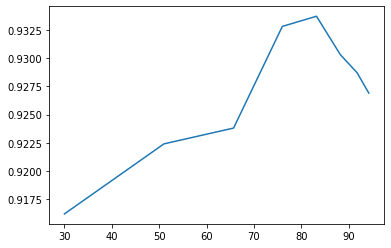

In [ ]:
x = list(iterative_accs_aft.keys())
y = list(iterative_accs_aft.values())
plt.plot(x,y)

In [ ]:
len(results_ap.keys())

21

In [ ]:
import pandas as pd

In [ ]:
results_ap_df = pd.DataFrame(results_ap)
results_ap_df.to_csv('results_ap_df_resnet_cifar10.csv')
results_ap_df_avg = results_ap_df.mean(axis=1)
results_ap_df_avg.iloc[0::2]

0     0.014081
2     0.036082
4     0.068423
6     0.106340
8     0.141548
10    0.173613
12    0.200851
14    0.230267
dtype: float64

In [ ]:
results_ap_df_avg_aft = pd.DataFrame(results_ap_df_avg.iloc[1::2])
results_ap_df_avg_aft['pr per'] = list(iterative_accs_aft.keys())
results_ap_df_avg_aft['accuracy'] = list(iterative_accs_aft.values())
results_ap_df_avg_aft

,0,pr per,accuracy
1,0.036526,30.000000,0.9162
3,0.069826,51.000004,0.9224
5,0.109339,65.700006,0.9238
7,0.147098,75.990000,0.9328
9,0.181925,83.193003,0.9337
11,0.212250,88.235104,0.9303
13,0.243797,91.764573,0.9287
15,0.274177,94.235198,0.9269


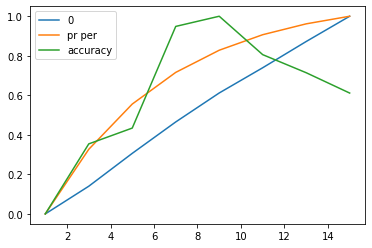

In [ ]:
normalized_df_aft=(results_ap_df_avg_aft-results_ap_df_avg_aft.min())/(results_ap_df_avg_aft.max()-results_ap_df_avg_aft.min())
normalized_df_aft.plot.line()

In [ ]:
results_ap_df_avg_bft = pd.DataFrame(results_ap_df_avg.iloc[::2])
results_ap_df_avg_bft['pr per'] = list(iterative_accs_bft.keys())
results_ap_df_avg_bft['accuracy'] = list(iterative_accs_bft.values())
results_ap_df_avg_bft

,0,pr per,accuracy
0,0.014081,30.000000,0.8991
2,0.036082,51.000004,0.8521
4,0.068423,65.700006,0.4474
6,0.106340,75.990000,0.7479
8,0.141548,83.193003,0.2510
10,0.173613,88.235104,0.3259
12,0.200851,91.764573,0.3764
14,0.230267,94.235198,0.2162


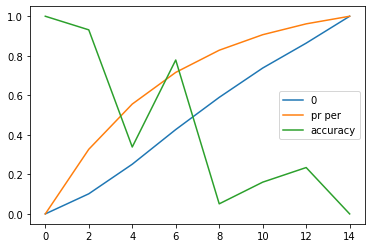

In [ ]:
normalized_df_bft=(results_ap_df_avg_bft-results_ap_df_avg_bft.min())/(results_ap_df_avg_bft.max()-results_ap_df_avg_bft.min())
normalized_df_bft.plot.line()

In [ ]:
normalized_df = pd.concat([normalized_df_bft, normalized_df_aft])
normalized_df = normalized_df.sort_index()
normalized_df

,0,pr per,accuracy
0,0.000000,0.000000,1.000000
1,0.000000,0.000000,0.000000
2,0.101768,0.326924,0.931176
3,0.140121,0.326924,0.354286
4,0.251368,0.555770,0.338556
5,0.306387,0.555770,0.434286
6,0.426756,0.715963,0.778591
7,0.465272,0.715963,0.948571
8,0.589616,0.828097,0.050959
9,0.611816,0.828097,1.000000


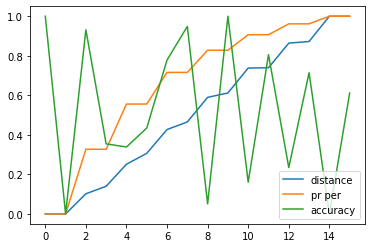

In [ ]:
normalized_df = normalized_df.rename(columns = {0:'distance'})
normalized_df.plot.line()